## Preparing the forcing files for a pre-industrial ocean-sea ice model spin-up following Huguenin et al. (2023)
- using JRA55-do-1-5-0 as input for the model
- only the surface air temperature, downward longwave radiation and specific humidity fields need to be changed
- the remaining variables are from the RDF (repeat decade forcing) period which includes the time 1962-01-01 to 1971-31-12
- reference: Huguenin, M.F., Holmes, R.M. & England, M.H. Drivers and distribution of global ocean heat uptake over the last half century. Nat Commun 13, 4921 (2022). https://doi.org/10.1038/s41467-022-32540-5

Maurice F. Huguenin, maurice.huguenin@whoi.edu, https://mauricehuguenin.github.io/, 19th February 2025

In [1]:
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm # for pretty ocean colour bars
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps                                                                   
import os.path # to check if file exists
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.mpl.ticker as cticker
from matplotlib import ticker
from netCDF4 import Dataset    # Note: python is case-sensitive!

import cartopy.feature as cfeature

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

from dask.distributed import Client
client = Client(n_workers=4)
client

2025-02-21 06:20:31,764 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/135667173.gadi-pbs/dask-worker-space/worker-d3qf753t', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46031,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:44823,Total threads: 7
Dashboard: /proxy/37779/status,Memory: 62.80 GiB
Nanny: tcp://127.0.0.1:37243,


## STEP I: Preparation of forcing fields for the pre-industrial run
- First, create the folders and subfolders in bash where the forcing files will get stored...only then will the script work properly
- This is how the file structure will look like ...
- ... and we run the cell below to create these folders

## Lavinia, you might have to adjust these strings below, depending which version of JRA55-do you use

In [2]:
# -------------------------------------------------------------------------------------------------------------------- #
forcing       = '1-5-0' # forcing = '1-3'                                    # @Lavinia, you might have to change this here if you use e.g., 1-5-1
save_location = '/g/data/e14/mv7494/HeatDist_input/'                         # the location where I save my newly calculated input files
experiment    = 'EXP_PI_Offset_JRA55-do-'+forcing + '/'                      # the experiment name for the pre-industrial spin-up
var           = ['uas','vas','tas','huss','rlds','rsds','prra','psl','prsn'] # only eight of the variables I used in my Msc
save          = '/g/data/e14/mv7494/HeatDist_figures/'                       # where to save the figures

# to accommodate the different forcing which has different naming conventions
if forcing == '1-3':
    base          = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/' # location where the OMIP-style JRA55-do files are located on the server
    fname         = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_'            # filename
    version       = 'gn/v20180412/'                                                     # version of the data set
    hrPt_timestep = ['01010000','12312230'] # some files have different names, according to their temporal resolution, so we need these strings too
    hr_timestep   = ['01010130','01010000']
    day_timestep  = [    '0101',    '0101']
if forcing == '1-5-0':
    base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/' # location where the OMIP-style JRA55-do files are located on the server
    fname = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_'           # filename
    version = 'gr/v20200916/'                                                    # version of the data set
    hrPt_timestep = ['01010000','12312100'] # some files have different names, according to their temporal resolution, so we need these strings too
    hr_timestep   = ['01010130','12312230']
    day_timestep  = [    '0101',    '0101']
# -------------------------------------------------------------------------------------------------------------------- #

In [3]:
pi_offset_variables = ['tas', 'rlds', 'huss']

# make the folders on the server in which I will save the new input fields of the model
os.system('mkdir ' + save_location + experiment)

# one subfolder for each variable of the pre-industrial spin-up
for f in range(3):
    os.system('mkdir ' + save_location + experiment +  pi_offset_variables[f]) 
# one subfolder for each ten-year period between the pre-industrial time and the 1962-71 repeat decade time (see dark blue line in Fig. 1a of Huguenin et al. 2022)
for i in range(191,199,1):
    os.system('mkdir ' + save_location + experiment + 'forcing_output' + str(i) + '/')
    # and finally within these folder one for each variable
    for f in range(3): 
        os.system('mkdir ' + save_location + experiment +  'forcing_output' + str(i) + '/' + pi_offset_variables[f]) # one subfolder for each variable

# I will get a few warnings here if the folders already exist but that's okay

mkdir: cannot create directory ‘/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-5-0/’: File exists
mkdir: cannot create directory ‘/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-5-0/tas’: File exists
mkdir: cannot create directory ‘/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-5-0/rlds’: File exists
mkdir: cannot create directory ‘/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-5-0/huss’: File exists
mkdir: cannot create directory ‘/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-5-0/forcing_output191/’: File exists
mkdir: cannot create directory ‘/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-5-0/forcing_output191/tas’: File exists
mkdir: cannot create directory ‘/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-5-0/forcing_output191/rlds’: File exists
mkdir: cannot create directory ‘/g/data/e14/mv7494/HeatDist_input/EXP_PI_Offset_JRA55-do-1-5-0/forcing_output191/huss’: File exists
mkdir: cannot create direc

The relative humidity is a function of the temperature:

$$e = \frac{qp}{0.622+0.378q}$$
$$e_s(T)=e_s(T_0) \times \exp{ \frac{L}{R_w} \left( \frac{1}{T_0}-\frac{1}{T} \right) } $$

$$q_{new} = \frac{e \times (0.622)}{\left( p\exp{ \frac{L}{R_w} \left( \frac{1}{T_{new}}-\frac{1}{T} \right) }- 0.378e \right) } $$  

So what I need to calculate pre-industrial specific humidity are the following files: 
- q_1962 (specific humidity of the 1962-71 decade)
- p_1962 (sea level pressure of ...)
- temp_1962 (surface air temperature of ...)
- temp_1859 (pre-industrial surface air temperature)

In [4]:
# pre-industrial offsets
pi_offsets = [     -0.133,       -0.7] # -0.133 °C for the tas (surface air temperature) field and -0.7 W/m2 for the rlds (downwelling longwave radiation) field
a = np.linspace(1962,1972,11) # time array for the Repeat Year Forcing (RYF) period, slightly longer so that it works out
                                  # hmaurice 20250219: I don't know why I did not make this array 10-years long, but should still work! :D

startTime = datetime.now() # start clock to give me a time stamp for each iteration of the loop  

print('#########################################')    
print('        '+experiment+'        ')
print('#########################################')
for i in [2,3,4]:                    # loop over the JRA55 variables that I need to change: tas, huss and rlds
    for year in range(0,10):         # loop over the first ten years, i.e., the RDF period from 1962-1971
        year_a = str(int(a[year]))
        year_aa = str(int(a[year+1]))
        startTime = datetime.now()   # start clock     
            
        print('Year ' + year_a + ' & ' + var[i])   # print year of current iteration

        # get correct subfolder, either 'atmos', 'land' or 'landIce'
        if var[i] == 'friver' and forcing == '1-3':
            domain = 'ocean/'
        elif var[i] == 'friver' and forcing == '1-4-0':
            domain = 'land/'
        elif var[i] == 'licalvf':
            domain = 'landIce/'
        else:
            domain = 'atmos/'

        # get correct resolution of forcing field, either '3hr', '3hrPt' or 'day'
        if var[i] in ['rsds','rlds','prra','prsn']:
            res = '3hr/'
        elif var[i] in ['psl','tas','huss','uas','vas']:
            res = '3hrPt/'
        else:
            res = 'day/'
         
        # load in data for RDF forcing 
        ds1 = xr.open_mfdataset(base + domain + res + var[i] + '/' + version + var[i] + fname + year_a + '*',combine = 'by_coords', 
                                chunks = {'time': 1},decode_times = True) # open dataset
        

        # -------------------------------------------------------------------------------------------------------- #
        # here calculate the pre-industrial offset adjustment                                                      #
        # -------------------------------------------------------------------------------------------------------- #
        if var[i] == 'tas':
            ds1['tas'] = ds1.tas + pi_offsets[0] # adjust with pre-industrial offset: substract 0.133 °C
                 
        if var[i] == 'rlds':
            ds1['rlds'] = ds1.rlds + pi_offsets[1] # adjust with pre-industrial offset: subtract 0.7 W m**-2
            
        if var[i] in ['huss']:
            # for the constant relative humidity calculation, I need RDF specific humidity, RDF sea level pressure as well as RDF and PI surface air temperature 
            huss_rdf = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',
                                         combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
            psl_rdf = xr.open_mfdataset(base + domain + res + var[7] + '/' + version + var[7] + fname + year_a + '*',
                                        combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset
            
            tas_pi = xr.open_mfdataset(save_location + experiment + var[2] + '/' + var[2] + fname + year_a + 
                                       hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                                       combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
            tas_rdf = xr.open_mfdataset(base + domain + res + var[2] + '/' + version + var[2] + fname + year_a + '*',
                                        combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset

            # copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
            # doing the calculations here for the relative humidity which are written as a proper mathematical formula in the cell above
            e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf)
            e_s_0 = 6.11*100  # [Pa]
            T_0 = 273.15      # [K]
            L = 2.5*10**6     # [J/kg]
            R_w = 462.52      # [J/(kg*K)]
            
            ds2 = e_rdf*0.622/(psl_rdf*np.exp(L/R_w *(1/tas_pi - 1/tas_rdf))-0.378*e_rdf) # my new specific pre-industrial specific humidity file that keeps relative humidity constant
                                                                                          # next step is saving that in a new .nc file
            # load in initial file to have the correct data structure
            ds1 = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True) # open dataset
            ds1['huss'] = ds2 # write my new huss data into this netcdf file

    # from here on save the files
    # different file names depending on the variables
        if var[i] in ['uas','vas','tas','psl','huss']:
            # construct filename for output file, e.g.
            filename = save_location + experiment + var[i] + '/' + var[i] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc'
            if os.path.isfile(filename) == True: # check if file already exists, if yes then I can skip that iteration which speeds up my script
                continue                
            else: 
                ds1.to_netcdf(filename) # if file not yet exists, save array to netcdf file

        elif var[i] in ['prra','prsn','rlds','rsds']:
            filename = save_location + experiment + var[i] + '/' + var[i] + fname + year_a + hr_timestep[0] + '-' + year_a + hr_timestep[1] + '.nc'
            if os.path.isfile(filename) == True:
                continue
            else: 
                ds1.to_netcdf(filename)
        elif var[i] == 'friver':
            if forcing == '1-3':
                filename = save_location + experiment + var[i]+ '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_a + day_timestep[1] + '.nc'
            else:
                filename = save_location + experiment + var[i]+ '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_a + day_timestep[1] + '.nc'

            if os.path.isfile(filename) == True:
                continue
            else: 
                ds1.to_netcdf(filename)

        print(datetime.now() - startTime) # end time of script
        #print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')    
    # Note: Saving one year of data takes 18 seconds
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    print('#           Variable finished           #')
    print('#########################################')

### Checking the TAS, RSDS and HUSS files if all calculations correct

#########################################
        EXP_PI_Offset_JRA55-do-1-5-0/        
#########################################
Year 1962 & tas
Year 1963 & tas
Year 1964 & tas
Year 1965 & tas
Year 1966 & tas
Year 1967 & tas
Year 1968 & tas
Year 1969 & tas
Year 1970 & tas
Year 1971 & tas
#           Variable finished           #
#########################################
Year 1962 & huss
Year 1963 & huss
Year 1964 & huss
Year 1965 & huss
Year 1966 & huss
Year 1967 & huss
Year 1968 & huss
Year 1969 & huss
Year 1970 & huss
Year 1971 & huss
#           Variable finished           #
#########################################
Year 1962 & rlds
Year 1963 & rlds
Year 1964 & rlds
Year 1965 & rlds
Year 1966 & rlds
Year 1967 & rlds
Year 1968 & rlds
Year 1969 & rlds
Year 1970 & rlds
Year 1971 & rlds
#           Variable finished           #
#########################################


In [5]:
save_location

'/g/data/e14/mv7494/HeatDist_input/'

### Checking if offset in TAS is correct

In [6]:
tas_rdf = xr.open_mfdataset(base + domain + '3hrPt/' + var[2] + '/' + version + var[2] + fname + '196201010000-196212312100.nc').tas[0,:,:].load() # open dataset
tas_pi  = xr.open_dataset(save_location + experiment + 'tas/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_196201010000-196212312100.nc').tas[0,:,:].load()

(tas_rdf-tas_pi).mean(['lat','lon']).values 
# ok, all correct. The pre-industrial offset is 0.1329956 °C

array(0.1329956, dtype=float32)

### Checking if offset in RLDS is correct

In [7]:
base + domain + '3hr/' + var[4] + '/' + version + var[4] + fname + '196201010130-196212312230.nc'

'/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hr/rlds/gr/v20200916/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_196201010130-196212312230.nc'

In [8]:
rlds_rdf = xr.open_mfdataset(base + domain + '3hr/' + var[4] + '/' + version + var[4] + fname + '196201010130-196212312230.nc').rlds[0,:,:].load() # open dataset
rlds_pi = xr.open_mfdataset(save_location + experiment + 'rlds/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_196201010130-196212312230.nc').rlds[0,:,:].load()


(rlds_rdf-rlds_pi).mean(['lat','lon']).values
# ok, all correct. The pre-industrial offset is 0.7 W m**-2

array(0.7000067, dtype=float32)

### Checking if relative humidity is constant

In [9]:
# load in all files required
huss_rdf = xr.open_mfdataset(base + 'atmos/3hrPt/' + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
huss_pi = xr.open_mfdataset(save_location + experiment + var[3] + '/' + var[3] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
psl_rdf = xr.open_mfdataset(base + 'atmos/3hrPt/' +  var[7] + '/' + version + var[7] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset

tas_pi = xr.open_mfdataset(save_location + experiment + var[2] + '/' + var[2] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
tas_rdf = xr.open_mfdataset(base + 'atmos/3hrPt/' + var[2] + '/' + version + var[2] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset

In [10]:
# copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf) # water vapour pressure in RDF period
e_pi = huss_pi*psl_rdf/(0.622+0.378*huss_pi)      # water vapour pressure in PI (pre-industrial) period

e_s_0 = 6.11*100 #Pa
T_0 = 273.15 #K

L = 2.5*10**6 #J/kg
R_w = 462.52#J/kgK


e_s_rdf = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_rdf)) # saturation water vapour pressure in RDF period
e_s_pi = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_pi))   # saturation water vapour pressure in PI period

rel_humid_rdf = e_rdf/e_s_rdf # relative humidity in RDF period
rel_humid_pi = e_pi/e_s_pi    # relative humidity in PI period

Text(0.5, 1.0, 'Change in RH')

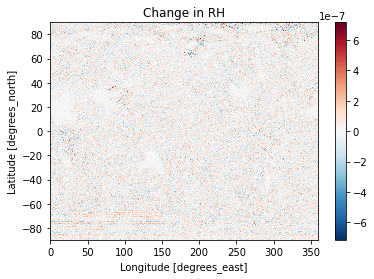

In [11]:
(rel_humid_rdf-rel_humid_pi).isel(time = 0).plot()
plt.title('Change in RH')

Note that the change in relative humidity is not exactly equal to zero because I have only used constants to 3 significant figures.

Text(0.5, 1.0, 'Relative error of change in RH')

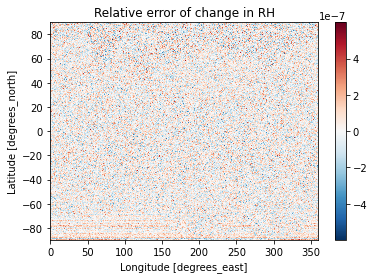

In [12]:
# relative error
((rel_humid_rdf-rel_humid_pi)/rel_humid_rdf).isel(time=2919).plot(); plt.title('Relative error of change in RH')

## STEP 2: Linearly decreasing the pre-industrial offset again over 80 years back to the repeat year 1962-71 decade
- I need to linearly increase the forcing files once again over nine decades with the last decade being the 1962-71 forcing with no changes
- from output192 (1882-91) to output200 (1962-71)

In [13]:
%%time
pi_offsets = [     -0.133,       -0.7]

slope =      np.abs([     -0.133/80,          -0.7/80])

lauf_variablen = [81,71,61,51,41,31,21,11] # this number goes from 80 during the first iteration (lauf_variable-1) down to 1
# and each time it gets multiplied with the -slope so it basically adds a positive increment to -0.133 all the way to 0.0 after 80 years

print('#########################################################')    
print('        '+experiment+'        ')
print('#########################################################')
for i in range(191,199,1): # loop over the 80 year period in which I progressively reduce the pre-industrial offset back to RDF levels again
                           # i.e., this is the forcing for the transitional spin-up period where the ocean emerges from pre-industrial conditions
                           # to the 1960s.
    experiment_long = experiment + 'forcing_output' + str(i) + '/'

    # output191 = RDF - PI-Offset
    # output192 = RDF - PI-Offset * 0.88
    # output193 = RDF - PI-Offset * 0.77
    # ...         ...               ...
    # output200 = RDF - PI-Offset * 0.00
    
    a = np.linspace(1962,1972,11)

    for v in [2,3,4]:                    # loop over the JRA55 variables that I need to change: tas, huss and rsds,          range(0,9):
        lauf_variable = lauf_variablen[i-191]  
        for year in range(0,10):         # loop over the first ten years, i.e., the RDF period  range(0,46):
            lauf_variable = lauf_variable - 1
            startTime = datetime.now()   # start clock
            # for tas:   -0.133°C * 0.88        + the difference between two ten year blocks multiplied by a 1/10th scaling factor
            # so  that the scaling goes over ten years from -0.133°C*0.88 up to -0.133°C*0.77
            if var[v] == 'tas':
                z = -slope[0]*lauf_variable # ich addiere jede iteration der Schlaufe 1/80stel des scaling factors hinzu bis dass ich nach 80 Jahren wieder bei 0.0 bin
                                            # output191 has scaling 1.0, ...then scaling back to 1962 levels and output200 has scaling 0.0
                                            # -> minus sign here because I need to positively add the slope so that the scaling decreases from -0.133 back to 0.0 
            elif var[v] == 'huss':
                z = 0
            elif var[v] == 'rlds':
                z = -slope[1]*lauf_variable
               
            year_a = str(int(a[year]))
            year_aa = str(int(a[year+1]))
            startTime = datetime.now()   # start clock                     
            
            print('Year ' + year_a + ' & ' + var[v]+': '+str(z))   # print year, variable and offset


            # get correct subfolder, either 'atmos', 'land' or 'landIce'
            if var[v] == 'friver' and forcing == '1-3':
                domain = 'ocean/'
            elif var[v] == 'friver' and forcing == '1-4-0':
                domain = 'land/'
            elif var[v] == 'licalvf':
                domain = 'landIce/'
            else:
                domain = 'atmos/'

            # get correct resolution of forcing field, either '3hr', '3hrPt' or 'day'
            if var[v] in ['rsds','rlds','prra','prsn']:
                res = '3hr/'
            elif var[v] in ['psl','tas','huss','uas','vas']:
                res = '3hrPt/'
            else:
                res = 'day/'

            # load in data for climatological RDF forcing 
            ds1 = xr.open_mfdataset(base + domain + res + var[v] + '/' + version + var[v] + fname + year_a + '*',combine = 'by_coords', 
                                    chunks = {'time': 1},decode_times = True) # open dataset


            # -------------------------------------------- #
            # pre-industrial offset adjustment here        #
            # -------------------------------------------- #
            if var[v] == 'tas':
                ds1['tas'] = ds1.tas + z
                # adjust with pre-industrial offset: substract 0.133 °C but now add a scaling factor to linearly go back to 1962-71 levels

            if var[v] == 'rlds':
                ds1['rlds'] = ds1.rlds + z
                # adjust with pre-industrial offset: subtract 0.7 W m**-2 but now add a scaling factor to linearly go back to 1962-71 levels

            if var[v] in ['huss']:
                # for the constant relative humidity calculation, I need RDF specific humidity, RDF sea level pressure as well as RDF and PI surface air temperature 
                huss_rdf = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',
                                             combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
                psl_rdf = xr.open_mfdataset(base + domain + res + var[7] + '/' + version + var[7] + fname + year_a + '*',
                                            combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset

                tas_pi = xr.open_mfdataset(save_location + experiment_long + var[2] + '/' + var[2] + fname + year_a + 
                                           hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                                           combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
                tas_rdf = xr.open_mfdataset(base + domain + res + var[2] + '/' + version + var[2] + fname + year_a + '*',
                                            combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset

                # copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
                e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf)
                e_s_0 = 6.11*100 #Pa
                T_0 = 273.15 #K
                
                L = 2.5*10**6 #J/kg
                R_w = 462.52#J/kgK

                ds2 = e_rdf*0.622/(psl_rdf*np.exp(L/R_w *(1/tas_pi - 1/tas_rdf))-0.378*e_rdf)
                # load in initial file to have the correct data structure
                ds1 = xr.open_mfdataset(base + domain + res + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True) # open dataset
                ds1['huss'] = ds2

        # from here on save the files
        # different file names depending on the variables
            if var[v] in ['uas','vas','tas','psl','huss']:
                # construct filename for output file, e.g.
                filename = save_location + experiment_long + var[v] + '/' + var[v] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc'
                if os.path.isfile(filename) == True: # check if file already exists, if yes then I can skip that iteration which speeds up my script
                    continue                
                else: 
                    ds1.to_netcdf(filename) # if file not yet exists, save array to netcdf file
            elif var[v] in ['prra','prsn','rlds','rsds']:
                filename = save_location + experiment_long + var[v] + '/' + var[v] + fname + year_a + hr_timestep[0] + '-' + year_a + hr_timestep[1] + '.nc'
                if os.path.isfile(filename) == True:
                    continue
                else: 
                    ds1.to_netcdf(filename)
            elif var[v] == 'friver':
                if forcing == '1-3':
                    filename = save_location + experiment_long + var[v]+ '/' + var[v] + fname + year_a + day_timestep[0] + '-' + year_a + day_timestep[1] + '.nc'
                else:
                    filename = save_location + experiment_long + var[v]+ '/' + var[v] + fname + year_a + day_timestep[0] + '-' + year_a + day_timestep[1] + '.nc'

                if os.path.isfile(filename) == True: # skip if file already exists
                    continue
                else: 
                    ds1.to_netcdf(filename)

            # ok this works, but is missing the lat/lon/bnds fields

            print(datetime.now() - startTime) # end time of script   
        # Note: Saving one month of data takes 18 seconds
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        print('---                 Variable finished                 ---')
        print('#########################################################')

### Wall time: 22 min 19s for a ten year block
#CPU times: user 58min 59s, sys: 4min 53s, total: 1h 3min 52s
# Wall time: 2h 40min 12s          for the full eight decades

#########################################################
        EXP_PI_Offset_JRA55-do-1-5-0/        
#########################################################
Year 1962 & tas: -0.133
Year 1963 & tas: -0.13133750000000002
Year 1964 & tas: -0.129675
Year 1965 & tas: -0.1280125
Year 1966 & tas: -0.12635000000000002
Year 1967 & tas: -0.1246875
Year 1968 & tas: -0.12302500000000001
Year 1969 & tas: -0.12136250000000001
Year 1970 & tas: -0.11970000000000001
Year 1971 & tas: -0.1180375
---                 Variable finished                 ---
#########################################################
Year 1962 & huss: 0
Year 1963 & huss: 0
Year 1964 & huss: 0
Year 1965 & huss: 0
Year 1966 & huss: 0
Year 1967 & huss: 0
Year 1968 & huss: 0
Year 1969 & huss: 0
Year 1970 & huss: 0
Year 1971 & huss: 0
---                 Variable finished                 ---
#########################################################
Year 1962 & rlds: -0.7
Year 1963 & rlds: -0.6912499999999999
Year 1964 & rlds: -0

### Checking if the linear scaling of the offset is done correctly, here for surface air temperature & longwave downward radiation

In [14]:
%%time

scale = np.linspace(1,0,10)

for i in range(191,199):

    period = 'output' + str(i)
    print(period)
    print('--- --- --- --- ---')

    lauf_variable = lauf_variablen[i-191]  
    lauf_variable = lauf_variable - 1
    print(lauf_variable)
   
    z1 = -slope[0]*lauf_variable; z2 = -slope[1]*lauf_variable 
    
    input = 'forcing_' + period
    tas_rdf      = xr.open_mfdataset(base + domain + '3hrPt/' + var[2] + '/' + version + var[2] + fname + '196201010000-196212312100.nc').tas[0,:,:].load() # open dataset
    tas_pi_scale = xr.open_dataset(save_location + experiment + input + '/tas/tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_196201010000-196212312100.nc').tas[0,:,:].load()

    print('[value from .nc file, manually calculated value, difference]')

    rlds_rdf = xr.open_mfdataset(base + domain + '3hr/' + var[4] + '/' + version + var[4] + fname + '196201010130-196212312230.nc').rlds[0,:,:].load() # open dataset
    rlds_pi_scale = xr.open_dataset(save_location + experiment + input + '/rlds/rlds_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr_196201010130-196212312230.nc').rlds[0,:,:].load()

    a = (tas_rdf-tas_pi_scale).mean(['lat','lon']).values      # the pi-offset value from the SAT .nc file
    b = abs(z1)                                                # the calculated pi-offset value
    c = (rlds_rdf-rlds_pi_scale).mean(['lat','lon']).values    # the pi-offset value from the RLDS .nc file
    d = abs(z2)                                                # the calculated pi-offset value
    print([a, b, a-b]) # ok, all correct. 
    print([c, d, c-d]) # ok, all correct. The pre-industrial offset is 0.7 W m**-2 * 0.88 = 0.622 for the output192 (the first scaling)

# NOICE!

output191
--- --- --- --- ---
80
[value from .nc file, manually calculated value, difference]
[array(0.1329956, dtype=float32), 0.133, -4.3945312500071054e-06]
[array(0.7000067, dtype=float32), 0.7, 6.723403930708471e-06]
CPU times: user 186 ms, sys: 27.4 ms, total: 213 ms
Wall time: 270 ms


### Checking if relative humidity is constant

EXP_PI_Offset_JRA55-do-1-5-0/


<timed exec>:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6


CPU times: user 2.53 s, sys: 276 ms, total: 2.8 s
Wall time: 15.8 s


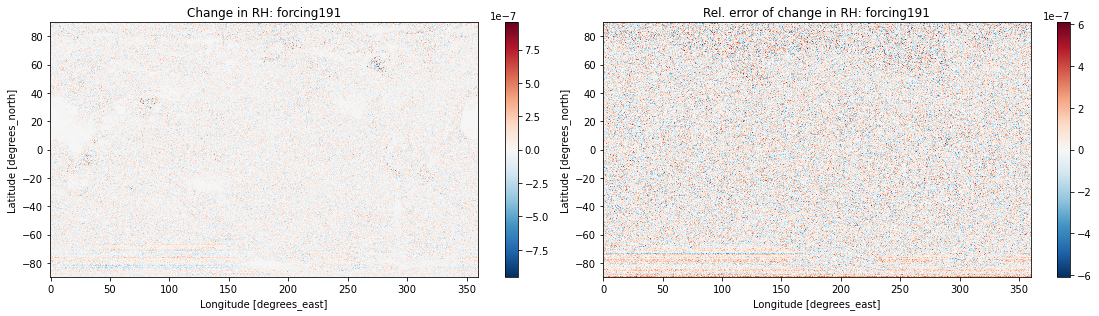

In [15]:
%%time

for i in range(192,201,1):
    print(experiment)
    
    year_a ='1962'; res = '3hrPt/'
    # load in all files required
    huss_rdf = xr.open_mfdataset(base + 'atmos/3hrPt/' + var[3] + '/' + version + var[3] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
    huss_pi = xr.open_mfdataset(save_location + experiment + var[3] + '/' + var[3] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                               combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).huss # open dataset
    psl_rdf = xr.open_mfdataset(base + 'atmos/3hrPt/' +  var[7] + '/' + version + var[7] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).psl # open dataset
    
    tas_pi = xr.open_mfdataset(save_location + experiment + var[2] + '/' + var[2] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc',
                               combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset
    tas_rdf = xr.open_mfdataset(base + 'atmos/3hrPt/' + var[2] + '/' + version + var[2] + fname + year_a + '*',combine = 'by_coords', chunks = {'time': '300MB'},decode_times = True).tas # open dataset


    # copied over from Claire's script on github: https://github.com/claireyung/unsw_clex_project_files/blob/main/humidity_forcing_modification-Copy1.ipynb
    e_rdf = huss_rdf*psl_rdf/(0.622+0.378*huss_rdf) # water vapour pressure in RDF period
    e_pi = huss_pi*psl_rdf/(0.622+0.378*huss_pi)      # water vapour pressure in PI (pre-industrial) period

    e_s_0 = 6.11*100 #Pa
    T_0 = 273.15 #K

    L = 2.5*10**6 #J/kg
    R_w = 462.52#J/kgK


    e_s_rdf = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_rdf)) # saturation water vapour pressure in RDF period
    e_s_pi = e_s_0 * np.exp(L/R_w*(1/T_0-1/tas_pi))   # saturation water vapour pressure in PI period

    rel_humid_rdf = e_rdf/e_s_rdf # relative humidity in RDF period
    rel_humid_pi = e_pi/e_s_pi    # relative humidity in PI period


    fig = plt.figure(figsize=(16,4.5),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(1,2) 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax1 = plt.subplot(gs[0,0])
    (rel_humid_rdf-rel_humid_pi).isel(time = 0).plot(); plt.title('Change in RH: forcing'+str(i))

    ax1 = plt.subplot(gs[0,1]) # relative error
    ((rel_humid_rdf-rel_humid_pi)/rel_humid_rdf).isel(time=2919).plot(); plt.title('Rel. error of change in RH: forcing'+str(i))

    # --- saving as 300 dpi .PNG image in specified folder ------------------------
    plt.savefig(save + 'checking_RH_forcing_constant_scaling_period_for_output'+str(i), dpi=300, facecolor='w', 
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None)
    # %% end of script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Wall time: 1min 57s
# All good, all figures show negligibly small changes in relative humidity (i.e., 1e6 magnitude smaller) and the relative error is also very, very small
# -> i.e., relative humidity is constant in all the scaling files

In [16]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #